In [1]:
import time
import numpy as np
import torch
from torch import nn
from tqdm import trange, tqdm

In [2]:
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

In [3]:
torch.backends.mps.is_available(), torch.cuda.is_available()

(True, False)

In [4]:
DATA_DIR = 'data/'

# Use the following code to load and normalize the dataset for training and testing
# It will downlad the dataset into data subfolder (change to your data folder name)

magic_number_1 = 0.1307
magic_number_2 = 0.3081

transform_for_data = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            (magic_number_1,),
            (magic_number_2,)
        )
    ]
)

train_dataset = torchvision.datasets.FashionMNIST(
    DATA_DIR,
    train=True,
    download=True,
    transform=transform_for_data,
)

test_dataset = torchvision.datasets.FashionMNIST(
    DATA_DIR,
    train=False,
    download=True,
    transform=transform_for_data,
)

In [5]:
# Use the following code to create a validation set of 10%
split_size = 0.1

train_indices, val_indices, _, _ = train_test_split(
    range(len(train_dataset)),
    train_dataset.targets,
    stratify=train_dataset.targets,
    test_size=split_size,
)

In [6]:
# Generate training and validation subsets based on indices
train_split = Subset(train_dataset, train_indices)
val_split = Subset(train_dataset, val_indices)

# set batches sizes
train_batch_size = 512 #Define train batch size
test_batch_size  = 256 #Define test batch size (can be larger than train batch size)

# Define dataloader objects that help to iterate over batches and samples for
# training, validation and testing
train_batches = DataLoader(train_split, batch_size=train_batch_size, shuffle=True)
val_batches = DataLoader(val_split, batch_size=train_batch_size, shuffle=True)
test_batches = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)
                                           
num_train_batches=len(train_batches)
num_val_batches=len(val_batches)
num_test_batches=len(test_batches)

print(num_train_batches)
print(num_val_batches)
print(num_test_batches)

106
12
40


In [7]:
#Sample code to visulaize the first sample in first 16 batches 

# batch_num = 0
# for train_features, train_labels in train_batches:
    
#     if batch_num == 16:
#         break    # break here
    
#     batch_num = batch_num +1
#     print(f"Feature batch shape: {train_features.size()}")
#     print(f"Labels batch shape: {train_labels.size()}")
    
#     img = train_features[0].squeeze()
#     label = train_labels[0]
#     plt.imshow(img, cmap="gray")
#     plt.show()
#     print(f"Label: {label}")

In [8]:
# # Sample code to plot N^2 images from the dataset
# def plot_images(XX, N, title):
#     fig, ax = plt.subplots(N, N, figsize=(8, 8))
    
#     for i in range(N):
#       for j in range(N):
#         ax[i,j].imshow(XX[(N)*i+j], cmap="Greys")
#         ax[i,j].axis("off")
#     fig.suptitle(title, fontsize=24)

# plot_images(train_dataset.data[:64], 8, "First 64 Training Images" )    

In [9]:
from torch.nn import functional as F

#Define your (As Cool As It Gets) Fully Connected Neural Network 
class ACAIGFCN(nn.Module):
    #Initialize model layers, add additional arguments to adjust
    def __init__(self, input_dim: int, output_dim: int, middle_layer_dims: list[int]): 
        super(ACAIGFCN, self).__init__()

        #Define the network layer(s) and activation function(s)
        if not middle_layer_dims:
            raise ValueError(f"No middle layers provided, expected at least one.")
        
        layers = []
        prev_dim = input_dim
        for dim in middle_layer_dims:
            layers.append(nn.Linear(prev_dim, dim))
            prev_dim = dim

        layers.append(nn.Linear(prev_dim, output_dim))
        self.layers = nn.ModuleList(layers)
 
    def forward(self, x):
        #Define how your model propagates the input through the network
        for layer in self.layers[:-1]:
            # x = nn.ReLU(layer(x))
            x = F.relu(layer(x))
        final_layer = self.layers[-1]
        return final_layer(x)
    
# model = ACAIGFCN(784, 10, [1024, 512, 128, 32])

In [14]:
# Initialize neural network model with input, output and hidden layer dimensions
model = ACAIGFCN(784, 10, [1024, 512, 256, 128, 64, 32, 16]) #... add more parameters
                
# Define the learning rate and epochs number
learning_rate = 0.003
epochs = 50


train_loss_list = np.zeros((epochs,))
validation_accuracy_list = np.zeros((epochs,))

# Define loss function  and optimizer
loss_func = torch.nn.CrossEntropyLoss() # Use Cross Entropy loss from torch.nn 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Use optimizers from torch.optim

In [15]:
# Run your training and validation loop and collect stats
train_loss = []
val_loss = []
train_acc = []
val_acc = []

# TODO: Is this a good way to calculate accuracy?
def acc(y_h, y_t):
    return (torch.softmax(y_h, 1).argmax(1) == y_t).float().mean()


loop = tqdm(total=len(train_batches) * epochs, position=0)

# Iterate over epochs, batches with progress bar and train+ validate the ACAIGFCN
# Track the loss and validation accuracy
for epoch in range(epochs):

    # ACAIGFCN Training 
    for train_features, train_labels in train_batches:
        # Set model into training mode
        model.train()
        
        # Reshape images into a vector
        train_features = train_features.reshape(-1, 28*28)

        optimizer.zero_grad()

        y_hat = model(train_features)
        loss = loss_func(y_hat, train_labels)

        loss.backward()
        optimizer.step()
        
        # loop.set_description(f"Epoch {epoch+1}/{epochs}")
        # loop.update(1)

        # Reset gradients, Calculate training loss on model 
        # Perfrom optimization, back propagation
        train_accuracy = acc(y_hat, train_labels)
        train_acc.append(train_accuracy)
 
        # Record loss for the epoch
        train_loss.append(loss.item())

        loop.set_description('epoch:{} train loss:{:.4f} train accuracy:{:.4f}'.format(epoch, train_loss[-1], train_accuracy))
        loop.update(1)

    current_val_acc = []
    current_val_loss = []
    
    # ACAIGFCN Validation
    for val_features, val_labels in val_batches:
        
        # Telling PyTorch we aren't passing inputs to network for training purpose
        with torch.no_grad(): 
            model.eval()
            
             # Reshape validation images into a vector
            val_features = val_features.reshape(-1, 28*28)

            y_hat = model(val_features)
            loss = loss_func(y_hat, val_labels)
          
            # Compute validation outputs (targets) 
            # and compute accuracy
            val_accuracy = acc(y_hat, val_labels)
            current_val_acc.append(val_accuracy)
            current_val_loss.append(loss.item())

    val_acc.append((len(train_acc), np.mean(current_val_acc)))
    val_loss.append((len(train_loss), np.mean(current_val_loss)))

    # loop.set_description(
    #     f"epoch:{epoch} train loss:{train_loss[-1]:.4f} train accuracy:{train_accuracy:.4f} val loss:{val_loss[-1][-1]:.4f} val accuracy:{val_acc[-1][-1]:.4f}"
    # )
    # loop.update(1)
            
    # Record accuracy for the epoch; print training loss, validation accuracy
    # print("Epoch: "+ str(epoch) +"; Validation Accuracy:" + str(val_acc/num_val_batches*100) + '%')

loop.close()

epoch:49 train loss:0.0465 train accuracy:0.9833: 100%|██████████| 5300/5300 [03:08<00:00, 28.05it/s]


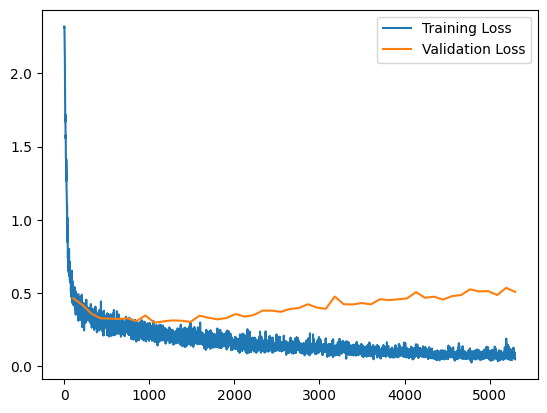

In [21]:
# Plot training loss and validation accuracy throughout the training epochs
plt.plot(train_loss, label='Training Loss')
plt.plot(np.array(val_loss)[:,0], np.array(val_loss)[:,1], label='Validation Loss')
plt.legend()
plt.show()

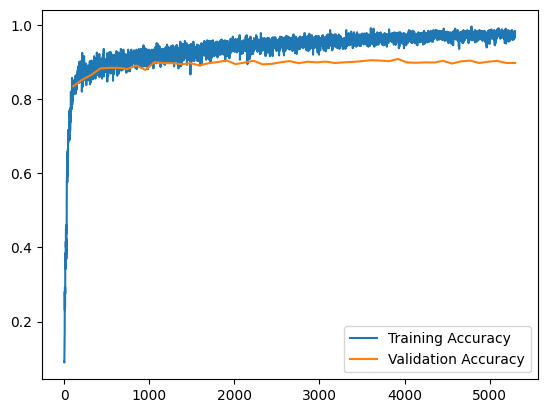

In [22]:
# Plot training loss and validation accuracy throughout the training epochs
plt.plot(train_acc, label='Training Accuracy')
plt.plot(np.array(val_acc)[:,0], np.array(val_acc)[:,1], label='Validation Accuracy')
plt.legend()
plt.show()

In [26]:
#Calculate accuracy on test set

test_acc = []

# Telling PyTorch we aren't passing inputs to network for training purpose
with torch.no_grad():
    
    for test_features, test_labels in test_batches:

        model.eval()
        # Reshape test images into a vector
        test_features = test_features.reshape(-1, 28*28)

        # Compute validation outputs (targets) 
        y_hat = model(test_features)
        test_acc.append(acc(y_hat, test_labels))
        # and compute accuracy 
    
    # Compute total (mean) accuracy
    # Report total (mean) accuracy, can also compute std based on batches

print(f"Mean Accuracy Across Each Batch of the test set: {np.mean(test_acc):.4f} ± {np.std(test_acc):.5f}")

Mean Accuracy Across Each Batch of the test set: 0.8905 ± 0.02280
